<a href="https://colab.research.google.com/github/navas604/Statistical-Learning-II/blob/main/Practica%202%20-%20Anomaly%20Detection%2C%20Dimesionality%20Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Universidad Galileo**
## **Maestría en Data Science**
## **Statistical Learning II**
## **Antonio Everardo Navas Contreras, 14003163**
## **28/07/2021**

---

## **PRÁCTICA 2 - ANOMALY DETECTION, DIMENSIONALITY REDUCTION**

---

### CARGAR LIBRERIAS

In [1]:
# Importar las librerías que se utilizarán

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

## **2.1 ANOMALY DETECTION**

### Calcular los parámetros de la distribución (Media y Desviación Estándar) usando dataset TRAIN

In [2]:
train_set = pd.read_csv("estaturasCSV.csv")
valtestCSV = pd.read_csv("valtestCSV.csv")
anomaliasCSV = pd.read_csv("anomaliasCSV.csv")

In [3]:
validation_set = pd.concat([valtestCSV.loc[:(len(valtestCSV)/2)-1,],
                            anomaliasCSV.loc[:(len(anomaliasCSV)/2)-1,]],
                           ignore_index = True)

test_set = pd.concat([valtestCSV.loc[len(valtestCSV)/2:,],
                      anomaliasCSV.loc[len(anomaliasCSV)/2:,]],
                     ignore_index = True)

In [4]:
validation_set

,Estatura(metros),Edad(años)
0,1.82,25.0
1,1.80,27.0
2,1.60,31.0
3,1.60,35.0
4,0.25,2.4
5,175.10,2.5


In [5]:
test_set

,Estatura(metros),Edad(años)
0,1.82,30.0
1,1.76,32.0
2,1.79,31.0
3,1.61,31.0
4,0.15,250.0
5,150.00,14.0


In [6]:
train_set

,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32
5,1.66,29
6,1.64,27
7,1.85,34
8,1.85,26
9,1.75,21


In [7]:
train_set.shape

(46, 2)

In [8]:
train_set.describe()

,Estatura(metros),Edad(años)
count,46.000000,46.000000
mean,1.732609,29.521739
std,0.075349,6.708996
min,1.550000,21.000000
25%,1.685000,25.000000
50%,1.730000,27.500000
75%,1.777500,32.750000
max,1.900000,53.000000


In [9]:
# Validar los tipos de variables

train_set.dtypes

Estatura(metros)    float64
Edad(años)            int64
dtype: object

In [10]:
# Porporción de NaN por columna

train_set.isna().sum() / len(train_set)

Estatura(metros)    0.0
Edad(años)          0.0
dtype: float64

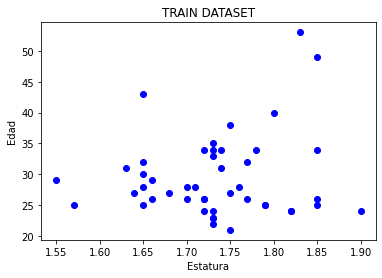

In [11]:
# Gráfica de los datos originales

plt.scatter(train_set.iloc[:,0], train_set.iloc[:,1], c="blue")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("TRAIN DATASET")
plt.show()

In [12]:
# Función que calcula los parámetros de una distribución Gaussiana Mu y Sigma

def estimate_gaussian(dataset):
  mu = np.mean(dataset, axis=0)
  sigma = np.cov(dataset.T)

  return mu, sigma

In [13]:
# Función que calcula la PDF de una distribución normal multivariada

def multivariate_gaussian(dataset, mu, sigma):
  gaussian_model = multivariate_normal(mean=mu, cov=sigma)
  
  return gaussian_model.pdf(dataset)

In [14]:
# Función que calcula el hyperparámetro EPSILON

def select_epsilon(probs, true_anomaly):
  best_epsilon = 0
  best_f1_score = 0
  actual_f1_score = 0

  step_size = (max(probs) - min(probs)) / 1000
  epsilons_list = np.arange(min(probs), max(probs), step_size)

  for epsilon in np.nditer(epsilons_list):
    predictions = (probs < epsilon)
    actual_f1_score = f1_score(true_anomaly.iloc[:,2], predictions, average = "binary")
    
    if (actual_f1_score > best_f1_score):
      best_f1_score = actual_f1_score
      best_epsilon = epsilon
      
  return best_f1_score, best_epsilon

In [15]:
# Función para detectar anomalías

def anomaly_detect(probs_list, epsilon, dataset_temp):
  dataset = dataset_temp.copy()
  anomalies_list = []
  for prob in probs_list:      
    if prob < epsilon:
      anomalies_list.append(True)
    else:
      anomalies_list.append(False)

  dataset['Anomalia'] = anomalies_list

  return dataset

In [16]:
# Parámetros mu y sigma con Train set

mu, sigma = estimate_gaussian(train_set)
mu, sigma

(Estatura(metros)     1.732609
 Edad(años)          29.521739
 dtype: float64, array([[5.67748792e-03, 7.54975845e-02],
        [7.54975845e-02, 4.50106280e+01]]))

In [17]:
# Train set

ocur_probs = multivariate_gaussian(train_set, mu, sigma)
ocur_probs

array([0.23431945, 0.31009622, 0.22670016, 0.2208083 , 0.15095585,
       0.19969697, 0.14680711, 0.0858851 , 0.07053945, 0.1298267 ,
       0.19727557, 0.1734548 , 0.09782319, 0.15281049, 0.1734548 ,
       0.24569404, 0.26016966, 0.02912061, 0.18582358, 0.28445693,
       0.26924266, 0.0752    , 0.06213504, 0.09782319, 0.1431563 ,
       0.25247859, 0.0162055 , 0.28624323, 0.24029438, 0.16971073,
       0.27630645, 0.01364933, 0.25481827, 0.2765844 , 0.00051524,
       0.17421813, 0.22602604, 0.16831363, 0.19727557, 0.01561357,
       0.27630645, 0.11492684, 0.22529554, 0.00246508, 0.29927816,
       0.28606927])

In [18]:
# Validation set

ocur_probs = multivariate_gaussian(validation_set, mu, sigma)
ocur_probs

array([1.12582041e-01, 1.86911763e-01, 6.00555552e-02, 3.72938536e-02,
       1.44657745e-85, 0.00000000e+00])

In [19]:
validation_set_true_anomaly = validation_set.copy()
validation_set_true_anomaly['Anomaly'] = [False, False, False, False,  True,  True]

In [20]:
# Seleccionar el mejor hyperparámetro EPSILON

best_f1, best_eps = select_epsilon(ocur_probs, validation_set_true_anomaly)
print('Best F1 Score:', best_f1)
print('Best Epsilon: ', best_eps)

Best F1 Score: 1.0
Best Epsilon:  0.00018691176319452995


In [21]:
# Detectar anomalías Validation Set

anomaly_validation = anomaly_detect(ocur_probs, best_eps, validation_set)
anomaly_validation

,Estatura(metros),Edad(años),Anomalia
0,1.82,25.0,False
1,1.80,27.0,False
2,1.60,31.0,False
3,1.60,35.0,False
4,0.25,2.4,True
5,175.10,2.5,True


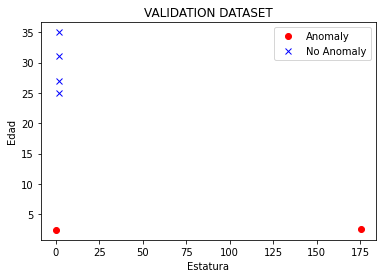

In [22]:
# Graficar anomalías y no anomalías Validation Set

anomaly = anomaly_validation[anomaly_validation['Anomalia'] == True]
no_anomaly = anomaly_validation[anomaly_validation['Anomalia'] == False]

plt.plot(anomaly.iloc[:,0], anomaly.iloc[:,1], "ro", label="Anomaly")
plt.plot(no_anomaly.iloc[:,0], no_anomaly.iloc[:,1], "bx", label="No Anomaly")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("VALIDATION DATASET")
plt.legend()
plt.show()

In [23]:
# Test set

ocur_probs = multivariate_gaussian(test_set, mu, sigma)
ocur_probs

array([0.16164905, 0.28329198, 0.23685512, 0.07591598, 0.        ,
       0.        ])

In [24]:
# Detectar anomalías Test Set

anomaly_test = anomaly_detect(ocur_probs, best_eps, test_set)
anomaly_test

,Estatura(metros),Edad(años),Anomalia
0,1.82,30.0,False
1,1.76,32.0,False
2,1.79,31.0,False
3,1.61,31.0,False
4,0.15,250.0,True
5,150.00,14.0,True


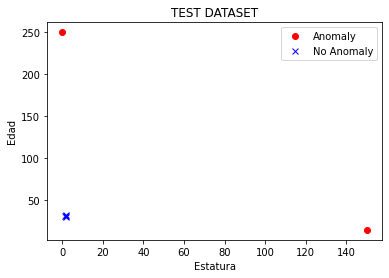

In [25]:
# Graficar anomalías y no anomalías Test Set

anomaly = anomaly_test[anomaly_test['Anomalia'] == True]
no_anomaly = anomaly_test[anomaly_test['Anomalia'] == False]

plt.plot(anomaly.iloc[:,0], anomaly.iloc[:,1], "ro", label="Anomaly")
plt.plot(no_anomaly.iloc[:,0], no_anomaly.iloc[:,1], "bx", label="No Anomaly")
plt.xlabel("Estatura")
plt.ylabel("Edad")
plt.title("TEST DATASET")
plt.legend()
plt.show()

## **2.2 DIMENSIONALITY REDUCTION**

### Cargamos la data 

El dataset Fashion-MNIST cotiene 60,000 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [26]:
fashion_mnist = keras.datasets.fashion_mnist

In [27]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

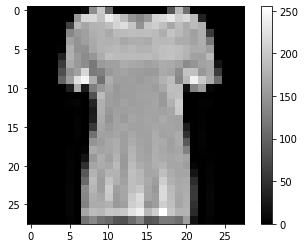

In [28]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

### Labels

In [29]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

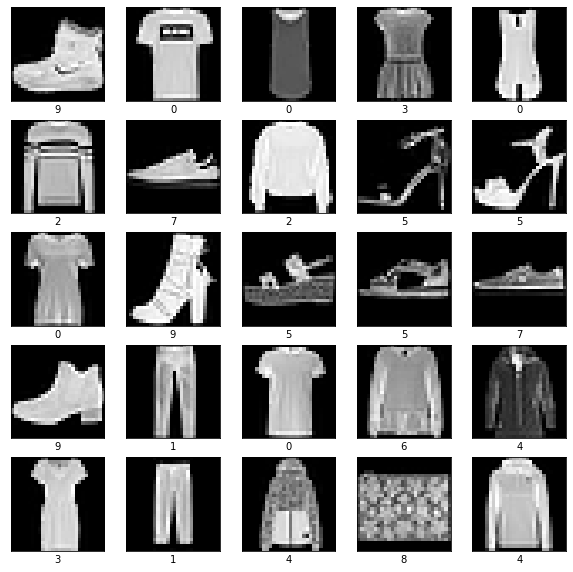

In [30]:
plt.figure(figsize=(10,10))

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap='gray')
  plt.xlabel(train_labels[i])
plt.show()

In [31]:
# Explorando el dataset completo

print("Train images type:", type(train_images))
print("Train images shape:", train_images.shape)
print("--------------------------------------------------")
print("Train labels type:", type(train_labels))
print("Train labels shape:", train_labels.shape)
print("--------------------------------------------------")
print("Test images type: ", type(test_images))
print("Test images shape: ", test_images.shape)
print("--------------------------------------------------")
print("Test labels type: ", type(test_labels))
print("Test labels shape: ", test_labels.shape)

Train images type: <class 'numpy.ndarray'>
Train images shape: (60000, 28, 28)
--------------------------------------------------
Train labels type: <class 'numpy.ndarray'>
Train labels shape: (60000,)
--------------------------------------------------
Test images type:  <class 'numpy.ndarray'>
Test images shape:  (10000, 28, 28)
--------------------------------------------------
Test labels type:  <class 'numpy.ndarray'>
Test labels shape:  (10000,)


### Reducir a 2 Dimensiones con PCA sin SKLEARN

In [32]:
def PCA_reduction(dataset):

  # Reshape del dataset para transformarlo a 2D
  dataset_2D = dataset.reshape(-1, dataset.shape[1] * dataset.shape[2]).astype(np.float32)

  # Calcular la Media y Desviación Estándar para cada feature
  media = dataset_2D.mean(axis=0).reshape(1, dataset_2D.shape[1])
  sd = dataset_2D.std(axis=0).reshape(1, dataset_2D.shape[1])

  # Normalizar el dataset
  dataset_norm = (dataset_2D - media) / sd

  # Calcular la matriz de covarianza
  sigma = np.cov(dataset_norm, rowvar = False)

  # Calcular Eigenvalues y Eigenvectors
  eigen_values , eigen_vectors = np.linalg.eigh(sigma)

  # Sacar los indices en forma descendente
  sorted_index = np.argsort(eigen_values)[::-1]

  # Ordenar los Eigenvalues de forma descendente
  sorted_eigenvalue = eigen_values[sorted_index]

  # Ordenar los Eigenvectors de forma descendente
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  # Seleccionar las n features o componentes para nuestro dataset final reducido
  n_components = 2
  reduced_eigenvector = sorted_eigenvectors[:,0:n_components]

  # Transformar el dataset original a n componente principales
  data_reduced = np.matmul(reduced_eigenvector.T, dataset_norm.T).T

  # Convertir el dataset final transformado a DataFrame de pandas
  data_reduced_df = pd.DataFrame(data_reduced, columns = ['PC1','PC2'])

  return data_reduced_df

In [33]:
# Se utiliza el dataset de Test ya que tiene menos data
# Se reduce a 2 dimensiones

test_images_PCA_reduced = PCA_reduction(test_images)
test_images_PCA_reduced

,PC1,PC2
0,-16.812915,-7.211606
1,22.272422,-9.561988
2,3.924984,16.794861
3,-4.979121,16.840424
4,2.306644,0.354440
...,...,...
9995,-5.932131,-16.013942
9996,-11.599839,14.494540
9997,-6.940739,8.629278
9998,-2.835373,15.493484


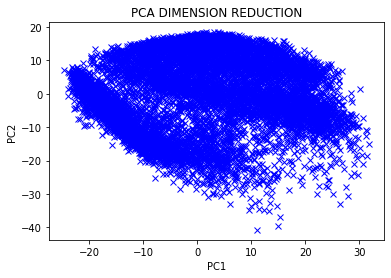

In [34]:
# Gráfica de los datos reducidos a 2 dimensiones

plt.plot(test_images_PCA_reduced.iloc[:,0], test_images_PCA_reduced.iloc[:,1], "bx")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA DIMENSION REDUCTION')
plt.show()

### Reducir a 2 Dimensiones con T-SNE con SKLEARN

In [35]:
# Reducción a 2 dimensiones con TSNE SKLEARN

test_images_2D = test_images.reshape(-1, test_images.shape[1] * test_images.shape[2]).astype(np.float32)

test_images_TSNE_reduced = TSNE(n_components=2, perplexity=50).fit_transform(test_images_2D)
test_images_TSNE_reduced = pd.DataFrame(test_images_TSNE_reduced, columns = ['PC1','PC2'])
test_images_TSNE_reduced

,PC1,PC2
0,-32.795013,-36.866657
1,60.805485,-2.239154
2,-34.203125,54.620304
3,-38.692780,43.969051
4,30.965912,-14.916605
...,...,...
9995,-18.905460,-49.885727
9996,-34.960415,37.468719
9997,1.702944,-22.901779
9998,-46.009712,37.087524


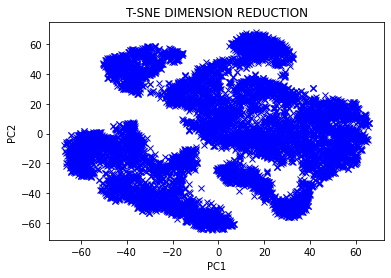

In [36]:
# Gráfica de los datos reducidos a 2 dimensiones

plt.plot(test_images_TSNE_reduced.iloc[:,0], test_images_TSNE_reduced.iloc[:,1], "bx")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('T-SNE DIMENSION REDUCTION')
plt.show()

Comparando ambas representaciones se puede visualizar que en PCA sin SKLEARN la distribución es menos uniforme de los datos, en la componente PC1 de -25 a 30 y la componente PC2 va de -40 a 20 aproximadamente. Mientras que en TSNE con SKLEARN es un poco mas uniforme la distribución de los datos, la componente PC1 va de -65 a 65 y la componente PC2 va de -60 a 60, se puede ver que los datos están enmarcados de una mejor forma.

In [37]:
# Función para graficar la data separada en clusters

def plot_clustered_data_GMM(gmm, dataset):
  clusters = gmm.predict(dataset)
  labels = ["cluster1", "cluster2", "cluster3", "cluster4" , "cluster5", "cluster6", "cluster7", "cluster8", "cluster9", "cluster10"]
  plt.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=clusters)
  plt.scatter(gmm.means_[:,0], gmm.means_[:,1], s=100, c="red", label="Centroids")
  plt.xlabel("Estatura")
  plt.ylabel("Edad")
  plt.title("CLUSTERED DATA WITH GMM")
  plt.legend()
  plt.show()

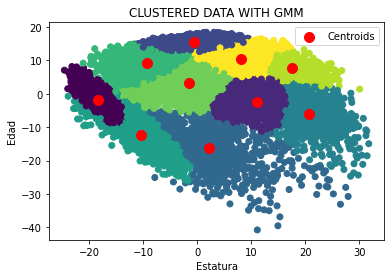

In [38]:
# Graficar el dataset reducido a 2 dimensiones con PCA sin SKLEARN

gmm_PCA = GaussianMixture(n_components=10, random_state=0).fit(test_images_PCA_reduced)

plot_clustered_data_GMM(gmm_PCA, test_images_PCA_reduced)

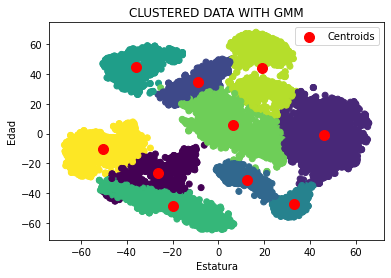

In [39]:
# Graficar el dataset reducido a 2 dimensiones con TSNE con SKLEARN

gmm_TSNE = GaussianMixture(n_components=10, random_state=0).fit(test_images_TSNE_reduced)

plot_clustered_data_GMM(gmm_TSNE, test_images_TSNE_reduced)

### CONCLUSIONES

*   Analizando el centroide de cada cluster podemos concluir que se podría asignar una categoría a cada cluster, aunque las distancias entre cada observación y su cluster son muy similares con otros clusters, es decir, las observaciones no están lo suficientemente separadas de los clusters a los que no pertenecen.

* Se puede observar que con TSNE los clusters están separados de mejor forma que con PCA, con PCA se vuelve mas complicado decidir entre algunos clusters.

*   La varianza intra-cluster es muy parecida a la varianza inter-cluster, por lo que crear categorías se complica, lo que se busca al hacer clustering es minimizar la varianza intra-cluster y maximizar la varianza inter-cluster.
